In [1]:
import pandas as pd

from rouge_score.rouge_scorer import RougeScorer

from resources.data import load_data, get_unique

In [2]:
metrics = ['rouge1', 'rougeL', 'rougeLsum']
scorer = RougeScorer(metrics)

In [3]:
texts = []

for entry in load_data(
        columns=['post_id', 'english_content_url', 'english_summary'],
        window=256,
        where='dataset = "manual_summary"',
        limit=100,
        db=1
    ):

    content = entry['english_content']
    
    rouge = [scorer.score(entry['english_summary'], part) for part in entry['english_content']['texts']]
    for m in metrics:
        content[m] = [s[m].fmeasure for s in rouge]

    content = pd.DataFrame(content, columns=['post_id', 'english_summary'] + list(content.keys()))
    content['post_id']         = entry['post_id']
    content['english_summary'] = entry['english_summary']

    texts.append(content)

texts = pd.concat(texts)
texts['rougeNorm'] = 0.
for post_id in texts.post_id.unique():
    mask = texts.post_id == post_id
    score = texts['rougeL'].values[mask]
    texts.loc[mask, 'rougeNorm'] = score / score.max()

texts.head()

SQL query:      "SELECT post_id, english_content_url, english_summary FROM `efra.summaries_v2_migrated` WHERE dataset = "manual_summary" LIMIT 100;"


/home/h21/kora8563/CNR-summaries/resources/data.py:23: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  def query_data(sql:str): return pd.read_gbq(sql, credentials=CREDENTIALS)


Retrieved data: 100 posts


100it [00:51,  1.95it/s]


,post_id,english_summary,part,paragraph,tokens,texts,rouge1,rougeL,rougeLsum,rougeNorm
0,7472062c-1335-488e-b319-4f2e73da19b5,Meat processors are in talks with the governme...,0,0,"[b, ', Getty, Images, Poultry, producers, said...",b' Getty Images \nPoultry producers said the s...,0.285714,0.139535,0.245847,0.940199
1,7472062c-1335-488e-b319-4f2e73da19b5,Meat processors are in talks with the governme...,1,0,"[``, This, crisis, highlights, the, fact, that...","""This crisis highlights the fact that the Brit...",0.225256,0.116041,0.191126,0.781895
2,7472062c-1335-488e-b319-4f2e73da19b5,Meat processors are in talks with the governme...,2,1,"[*, *, Gas, uses, *, *, Carbon, dioxide, is, u...",**Gas uses**\nCarbon dioxide is used when slau...,0.240283,0.148410,0.183746,1.000000
0,c5c108fa-9b42-4fc1-aa2b-aedbafb0f513,A new type of recyclable meat packaging tray d...,0,0,"[b, ', *, *, A, new, type, of, recyclable, mea...",b' \n**A new type of recyclable meat packaging...,0.708108,0.572973,0.664865,1.000000
1,c5c108fa-9b42-4fc1-aa2b-aedbafb0f513,A new type of recyclable meat packaging tray d...,1,0,"[He, said, :, ``, You, can, turn, it, upside, ...","He said: ""You can turn it upside down, shake i...",0.365591,0.150538,0.322581,0.262731


In [4]:
post_id = texts.post_id.unique()[1]
j = texts[texts.post_id == post_id]['rougeNorm'].values.argmax()

print('SUMMARY:', texts[texts.post_id == post_id]['english_summary'].values[j])
print()
print('MOST SIMILAR PART:', texts[texts.post_id == post_id]['texts'].values[j])
print()
texts[texts.post_id == post_id]

SUMMARY: A new type of recyclable meat packaging tray designed by a Swansea University student could save thousands of tonnes in plastic waste. 
In partnership with packaging manufacturers Klöckner Pentaplast, the design of the meat tray without a separate piece of absorbent plastic padding underneath is already being used by leading UK food suppliers and retailers, including Sainsbury's and Asda. The meat tray is 100% recyclable and allows consumers to look at meat from all angles through the clear plastic. The design allows moisture into specially designed wells, but would not let it back out.

The packaging can then be washed under a tap, meaning the plastic is chemically and biologically safe to be recycled along with other household items, as per the designer Alaa Alaizoki. The technology has only been patented for use in food packaging, but Mr Alaizoki said it could have many more uses.

MOST SIMILAR PART: b' 
**A new type of recyclable meat packaging tray designed by a Swansea U

,post_id,english_summary,part,paragraph,tokens,texts,rouge1,rougeL,rougeLsum,rougeNorm
0,c5c108fa-9b42-4fc1-aa2b-aedbafb0f513,A new type of recyclable meat packaging tray d...,0,0,"[b, ', *, *, A, new, type, of, recyclable, mea...",b' \n**A new type of recyclable meat packaging...,0.708108,0.572973,0.664865,1.000000
1,c5c108fa-9b42-4fc1-aa2b-aedbafb0f513,A new type of recyclable meat packaging tray d...,1,0,"[He, said, :, ``, You, can, turn, it, upside, ...","He said: ""You can turn it upside down, shake i...",0.365591,0.150538,0.322581,0.262731
2,c5c108fa-9b42-4fc1-aa2b-aedbafb0f513,A new type of recyclable meat packaging tray d...,2,0,"[``, The, lamb, and, beef, sector, in, Wales, ...","""The lamb and beef sector in Wales is renowned...",0.148936,0.074468,0.095745,0.129968


array([[<Axes: title={'center': 'rouge1'}>,
        <Axes: title={'center': 'rougeL'}>],
       [<Axes: title={'center': 'rougeLsum'}>,
        <Axes: title={'center': 'rougeNorm'}>]], dtype=object)

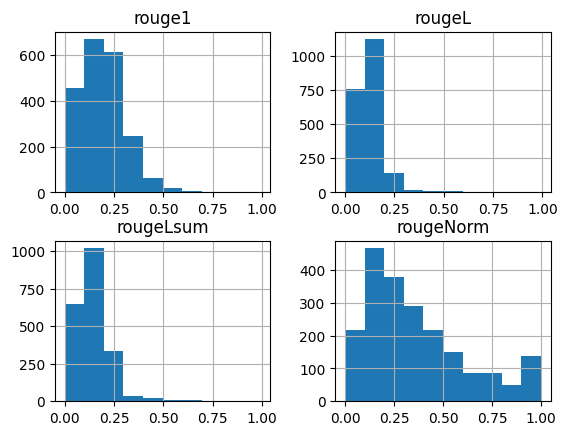

In [5]:
texts.hist()

<Axes: xlabel='partNorm'>

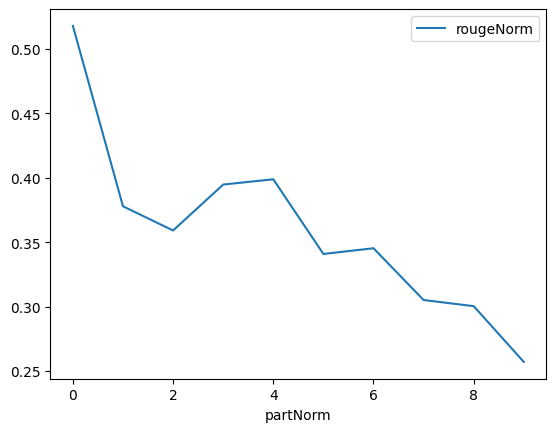

In [6]:
texts['partNorm'] = 0.

for post_id in texts.post_id.unique():
    mask = texts.post_id == post_id
    score = texts['part'].values[mask].astype(int)
    texts.loc[mask, 'partNorm'] = score / score.max()

texts['partNorm'] = pd.cut(texts['partNorm'], 
    bins=[-.01, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.],
    labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
)

texts[['partNorm', 'rougeNorm']].groupby('partNorm', observed=False).mean().plot()